# CVI Experiment Suite

This notebook runs a comprehensive grid search over Characteristic Value Iteration (CVI) hyperparameters and compares performance against classical baselines (VI, Monte Carlo).

In [1]:
import sys
import os
import numpy as np
import itertools
import pandas as pd
import gymnasium as gym
from tqdm.notebook import tqdm

# CVI Imports
from cvi_rl.envs.registry import make_env
from cvi_rl.algorithms.tabular_vi import value_iteration
from cvi_rl.algorithms.mc import evaluate_policy_monte_carlo
from cvi_rl.algorithms.tabular_cvi import cvi_policy_evaluation, cvi_action_evaluation_from_V, collapse_q_cf_to_scalar_mean
from cvi_rl.cf.grids import make_omega_grid

## 1. Environment Setup

We use a standard tabular environment. Valid options: `"taxi"`, `"gridworld"`, `"frozenlake-8x8"`.

In [2]:
ENV_NAME = "taxi"
GAMMA = 0.9

# Initialize Environment
env_spec, env = make_env(ENV_NAME)
print(f"Initialized {ENV_NAME}: States={env_spec.n_states}, Actions={env_spec.n_actions}")

# Initial Policy (Random)
np.random.seed(42)
random_policy = np.random.randint(0, env_spec.n_actions, size=env_spec.n_states)

# Compute Ground Truth via Classical VI
print("Running Classical Value Iteration for Baseline...")
pi_vi, V_vi, _, _ = value_iteration(env_spec, gamma=GAMMA, termination=1e-8)

# Compute Q_vi from V_vi for direct comparison
# We need Q-values to compare against CVI's collapsed Q(s,a)
Q_vi = np.zeros((env_spec.n_states, env_spec.n_actions))
for s in range(env_spec.n_states):
    for a in range(env_spec.n_actions):
        for prob, next_state, reward, done in env_spec.P[s][a]:
            Q_vi[s, a] += prob * (reward + GAMMA * V_vi[next_state] * (1 - done))

print(f"VI Converged. Q_vi shape: {Q_vi.shape}, Mean Q-value: {Q_vi.mean():.3f}")

Initialized taxi: States=500, Actions=6
Running Classical Value Iteration for Baseline...
VI Converged. Q_vi shape: (500, 6), Mean Q-value: -1.675


## 2. Experiment Grid Definition

We define the hyperparameter space for CVI. We will explore:
1. **Grid Construction**: Strategy (Uniform vs Piecewise, logarithmic, chebyshev, and adaptive), Size (K), Range (W)
2. **Interpolation**: Linear, Polar, PCHIP, Lanczos
3. **Collapse Method**: How we extract the scalar mean from the CF (LS, FFT, Gaussian)

In [3]:
# Define the parameter grid
param_grid = {
    # Grid Parameters
    "W": [10.0, 20.0],           # Frequency range [-W, W]
    "K": [128, 256, 512],        # Number of grid points
    "grid_strategy": ["uniform", "two_density_regions", "three_density_regions", "four_density_regions", "exponential_decay", "linear_decay", "quadratic_decay"],
    
    # CVI Core Parameters
    "interp_method": ["linear", "polar", "pchip", "lanczos"],
    
    # Post-Processing / Collapse Parameters
    "collapse_method": ["ls", "fft", "gaussian"]
}

# Generate all combinations
keys, values = zip(*param_grid.items())
configs = [dict(zip(keys, v)) for v in itertools.product(*values)]

print(f"Total possible configurations: {len(configs)}")

# Filter incompatible combinations
filtered_configs = []
for cfg in configs:
    # FFT assumes uniform grid structure for standard inversion
    # Allow only uniform grids for FFT (could extend to others but needs validation)
    if cfg["collapse_method"] == "fft" and cfg["grid_strategy"] != "uniform":
        continue
        
    filtered_configs.append(cfg)

print(f"Configurations after filtering: {len(filtered_configs)}")
print(f"\nGrid strategy distribution:")
for strategy in param_grid["grid_strategy"]:
    count = sum(1 for cfg in filtered_configs if cfg["grid_strategy"] == strategy)
    print(f"  {strategy:20s}: {count} configs")
print(f"\nExample Config:", filtered_configs[0])

Total possible configurations: 504
Configurations after filtering: 360

Grid strategy distribution:
  uniform             : 72 configs
  two_density_regions : 48 configs
  three_density_regions: 48 configs
  four_density_regions: 48 configs
  exponential_decay   : 48 configs
  linear_decay        : 48 configs
  quadratic_decay     : 48 configs

Example Config: {'W': 10.0, 'K': 128, 'grid_strategy': 'uniform', 'interp_method': 'linear', 'collapse_method': 'ls'}


## 3. Helper Functions for Evaluation

We define metrics to compare the CVI-derived Q-values against the Classical VI Q-values ($Q_{VI}$).

In [4]:
def evaluate_config(config, env_spec, policy, Q_target):
    """
    Runs CVI policy evaluation with the given config and compares to Q_target.
    """
    # 1. Run CVI Policy Evaluation
    # Some interpolation methods might need specific kwargs (e.g. lanczos 'a')
    interp_kwargs = {}
    if config["interp_method"] == "lanczos":
        interp_kwargs = {"a": 3}
    
    V_cf, omegas = cvi_policy_evaluation(
        env_spec,
        policy,
        gamma=GAMMA,
        grid_strategy=config["grid_strategy"],
        W=config["W"],
        K=config["K"],
        interp_method=config["interp_method"],
        interp_kwargs=interp_kwargs
    )
    
    # 2. Compute Action Values CF
    Q_cf = cvi_action_evaluation_from_V(
        env_spec,
        V_cf,
        omegas,
        gamma=GAMMA,
        interp_method=config["interp_method"],
        interp_kwargs=interp_kwargs
    )
    
    # 3. Collapse to Scalar
    # Collapse kwargs dispatch
    collapse_kwargs = {}
    if config["collapse_method"] == "ls":
        collapse_kwargs = {"m": 4}
    elif config["collapse_method"] == "gaussian":
        collapse_kwargs = {"max_w": 2.0}
    elif config["collapse_method"] == "savgol":
        collapse_kwargs = {"window_length": 7}
        
    Q_cvi_scalar = collapse_q_cf_to_scalar_mean(
        omegas,
        Q_cf,
        method=config["collapse_method"],
        **collapse_kwargs
    )
    
    # 4. Metrics
    # State-space error metrics
    errors = Q_cvi_scalar - Q_target
    abs_errors = np.abs(errors)
    squared_errors = errors ** 2
    
    mae = np.mean(abs_errors)           # Mean Absolute Error
    mse = np.mean(squared_errors)       # Mean Squared Error
    rmse = np.sqrt(mse)                 # Root Mean Squared Error
    max_err = np.max(abs_errors)        # Maximum Error
    
    return {
        "mae": mae,
        "mse": mse,
        "rmse": rmse,
        "max_err": max_err,
        "q_mean": np.mean(Q_cvi_scalar)
    }

## 4. Run Experiments

In [ ]:
# Run grid search
results = []

print(f"Running {len(filtered_configs)} configurations...\n")

for i, config in enumerate(tqdm(filtered_configs)):
    try:
        metrics = evaluate_config(config, env_spec, pi_vi, Q_vi)
        
        # Add config params to results
        result = {**config, **metrics}
        results.append(result)
        
    except Exception as e:
        print(f"\nConfig {i} failed: {config}")
        print(f"Error: {e}\n")
        continue

# Convert to DataFrame
df_results = pd.DataFrame(results)
print(f"\nCompleted {len(df_results)} / {len(filtered_configs)} configurations successfully.")
print(f"\nBest 5 configurations by MAE:")
print(df_results.nsmallest(5, 'mae')[['W', 'K', 'grid_strategy', 'interp_method', 'collapse_method', 'mae', 'mse', 'rmse', 'max_err']])

Running 360 configurations...



  0%|          | 0/360 [00:00<?, ?it/s]


Completed 360 / 360 configurations successfully.

Best 5 configurations by MAE:
        W    K          grid_strategy interp_method collapse_method  \
271  20.0  256   four_density_regions         polar        gaussian   
47   10.0  128           linear_decay         polar        gaussian   
55   10.0  128        quadratic_decay         polar        gaussian   
203  20.0  128  three_density_regions         polar        gaussian   
75   10.0  256    two_density_regions         polar        gaussian   

              mae           mse          rmse       max_err  
271  1.274980e-15  2.742327e-30  1.655997e-15  3.552714e-15  
47   1.992702e-15  5.171752e-30  2.274149e-15  3.552714e-15  
55   2.191950e-15  6.185109e-30  2.486988e-15  3.552714e-15  
203  2.257083e-15  7.069209e-30  2.658798e-15  4.440892e-15  
75   2.276993e-15  8.202904e-30  2.864071e-15  7.105427e-15  


In [10]:
df_results.to_csv('results/cvi_gridsearch_taxi.csv', index=False)

In [14]:
print(df_results.nlargest(40, 'mae')[['W', 'K', 'grid_strategy', 'interp_method', 'collapse_method', 'mae', 'mse', 'rmse', 'max_err']])

        W    K         grid_strategy interp_method collapse_method        mae  \
187  20.0  128               uniform         pchip             fft  26.611352   
181  20.0  128               uniform        linear             fft  19.503462   
5    10.0  128               uniform         polar        gaussian  18.319087   
4    10.0  128               uniform         polar             fft  11.434676   
127  10.0  512               uniform         pchip             fft  11.275431   
1    10.0  128               uniform        linear             fft  11.142414   
304  20.0  512               uniform         polar             fft  11.099583   
124  10.0  512               uniform         polar             fft  11.099561   
64   10.0  256               uniform         polar             fft  11.099515   
241  20.0  256               uniform        linear             fft  11.098735   
244  20.0  256               uniform         polar             fft  11.079304   
70   10.0  256              

## 5. Analysis and Visualization

Analyze the results to understand which hyperparameters work best.


In [6]:
import matplotlib.pyplot as plt

# Overall statistics
print("Summary Statistics:")
print(df_results[['mae', 'mse', 'rmse', 'max_err']].describe())

# Best configuration
best_idx = df_results['mae'].idxmin()
best_config = df_results.loc[best_idx]
print(f"\nBest Configuration:")
print(f"  Grid: {best_config['grid_strategy']}, W={best_config['W']}, K={best_config['K']}")
print(f"  Interpolation: {best_config['interp_method']}")
print(f"  Collapse: {best_config['collapse_method']}")
print(f"  MAE: {best_config['mae']:.6f}")
print(f"  MSE: {best_config['mse']:.6f}")
print(f"  RMSE: {best_config['rmse']:.6f}")
print(f"  Max Error: {best_config['max_err']:.6f}")

# Grouped analysis
print("\n" + "="*60)
print("Error Metrics by Grid Strategy:")
print(df_results.groupby('grid_strategy')[['mae', 'mse', 'rmse']].agg(['mean', 'std', 'min']))

print("\n" + "="*60)
print("Error Metrics by Interpolation Method:")
print(df_results.groupby('interp_method')[['mae', 'mse', 'rmse']].agg(['mean', 'std', 'min']))

print("\n" + "="*60)
print("Error Metrics by Collapse Method:")
print(df_results.groupby('collapse_method')[['mae', 'mse', 'rmse']].agg(['mean', 'std', 'min']))

print("\n" + "="*60)
print("Error Metrics by K (Grid Size):")
print(df_results.groupby('K')[['mae', 'mse', 'rmse']].agg(['mean', 'std', 'min']))


Summary Statistics:
                mae           mse          rmse       max_err
count  3.600000e+02  3.600000e+02  3.600000e+02  3.600000e+02
mean   2.508649e+00  6.357082e+01  3.632343e+00  1.282755e+01
std    3.640306e+00  5.503117e+02  7.107547e+00  3.060545e+01
min    1.274980e-15  2.742327e-30  1.655997e-15  3.552714e-15
25%    4.110958e-03  3.020456e-05  5.478065e-03  1.700684e-02
50%    3.202143e-01  4.120939e-01  6.389555e-01  5.635763e+00
75%    4.245837e+00  3.537565e+01  5.947737e+00  2.005107e+01
max    2.661135e+01  1.006420e+04  1.003205e+02  4.917457e+02

Best Configuration:
  Grid: four_density_regions, W=20.0, K=256
  Interpolation: polar
  Collapse: gaussian
  MAE: 0.000000
  MSE: 0.000000
  RMSE: 0.000000
  Max Error: 0.000000

Error Metrics by Grid Strategy:
                            mae                                 mse  \
                           mean       std           min        mean   
grid_strategy                                                      

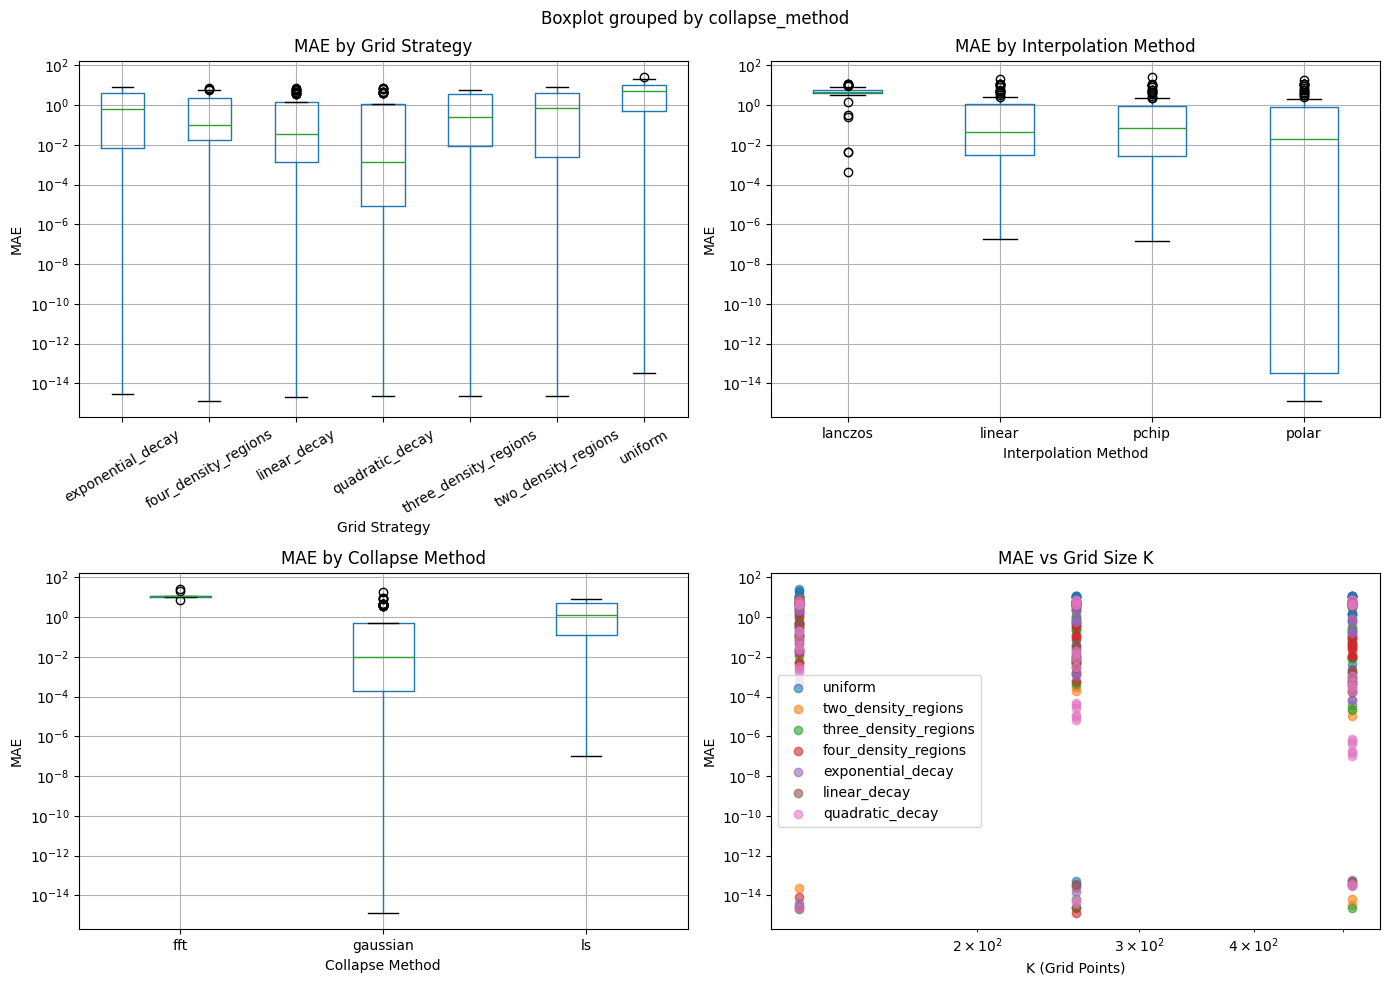

In [9]:
# Visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# MAE by grid strategy
df_results.boxplot(column='mae', by='grid_strategy', ax=axes[0, 0])
axes[0, 0].set_title('MAE by Grid Strategy')
axes[0, 0].set_xlabel('Grid Strategy')
axes[0, 0].set_ylabel('MAE')
axes[0, 0].set_yscale('log')
axes[0, 0].set_xticklabels(axes[0, 0].get_xticklabels(), rotation=30)

# MAE by interpolation method
df_results.boxplot(column='mae', by='interp_method', ax=axes[0, 1])
axes[0, 1].set_title('MAE by Interpolation Method')
axes[0, 1].set_xlabel('Interpolation Method')
axes[0, 1].set_ylabel('MAE')
axes[0, 1].set_yscale('log')

# MAE by collapse method
df_results.boxplot(column='mae', by='collapse_method', ax=axes[1, 0])
axes[1, 0].set_title('MAE by Collapse Method')
axes[1, 0].set_xlabel('Collapse Method')
axes[1, 0].set_ylabel('MAE')
axes[1, 0].set_yscale('log')

# MAE vs K (grid size)
for strategy in df_results['grid_strategy'].unique():
    data = df_results[df_results['grid_strategy'] == strategy]
    axes[1, 1].scatter(data['K'], data['mae'], label=strategy, alpha=0.6)
axes[1, 1].set_title('MAE vs Grid Size K')
axes[1, 1].set_xlabel('K (Grid Points)')
axes[1, 1].set_ylabel('MAE')
axes[1, 1].legend()
axes[1, 1].set_xscale('log')
axes[1, 1].set_yscale('log')

plt.tight_layout()
plt.show()